# Climatic Analysis

Performing climatic analysis of Hawaii based on the temperature recorded on different stations

In [79]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.sql import label
from sqlalchemy import func
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
import pandas as pd
from sqlalchemy import Column, Integer, String, Numeric, Text, Float,Table,ForeignKey
from flask import jsonify

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib

from datetime import datetime,timedelta

In [16]:
engine = create_engine("sqlite:///hawaii.sqlite")
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

Measurements = Base.classes.measurements
Stations = Base.classes.stations

session = Session(engine)

my_table = Table('Measurements', Base.metadata, 
    Column("station", String, ForeignKey("Stations.station")),
    autoload=True,autoload_with=engine)

# Precipitation analysis

In [17]:
def precipitation_data():
    current_time = datetime.now()

    past_year = current_time - timedelta(days=365)

    measurements_year = session.query(Measurements.date,Measurements.prcp).filter(
        Measurements.date > past_year).all()

    measure_records = []
    for measure in measurements_year:
        measure_records.append(measure._asdict())

    measurements_df = pd.DataFrame.from_records(measure_records)

    measurements_df = measurements_df.set_index('date')


    return measurements_df

In [19]:
def showprecipitation():
    measurements_df = precipitation_data()

    measurements_df.plot(kind="line",linewidth=4,figsize=(15,10))

    plt.style.use('fivethirtyeight')

    matplotlib.rcParams.update({'font.size': 16})

    plt.xlabel("Date")
    plt.ylabel("Precipitation")
    plt.title(f"Precipitation analysis of past year")
    plt.xticks(rotation=45)
    plt.legend(["Precipitation"])
    plt.tight_layout()
    plt.savefig("figures/PrecipitationAnalysis_Hawaii.png")

    plt.show()

# Station Analysis

In [20]:
def gettotalstations():
    total_stations = session.query(Stations).distinct().count()
    print(f"Total number of stations: {total_stations}")

In [21]:
def stations_wfrequency():
    active_stations = session.query(Stations.name,Stations.station,label('number_of_obs',func.count(Measurements.id))).\
                    filter(Measurements.station == Stations.station).\
    group_by(Stations.name,Stations.station).order_by(func.count(Measurements.id).desc())
    
    active_station_records = []
    for station in active_stations:
        active_station_records.append(station._asdict())

    active_station_df = pd.DataFrame.from_records(active_station_records)
    
    return active_station_df

In [22]:
def getstationslist():
    active_station_df = stations_wfrequency()

    stations = active_station_df[['name','station']]

    return stations

In [55]:
def getmostfreqstation():
    active_station_df = stations_wfrequency()
    
    freq_station = {'id':"",'name':""}
    freq_station['id'] = active_station_df.iloc[:1]['station'][0]

    freq_station['name'] = active_station_df.iloc[:1]['name'][0]
    
    return freq_station

In [56]:
def get_temperature_obs():
    current_time = datetime.now()

    past_year = current_time - timedelta(days=365)
    
    freq_station_id = getmostfreqstation()['id']

    measure_freq_station = session.query(Measurements.date,Measurements.tobs).\
                        filter(Measurements.station == freq_station_id).\
                        filter(Measurements.date > past_year).all()

    station_measures = []
    for measure in measure_freq_station:
        station_measures.append(measure._asdict())

    station_measures_df = pd.DataFrame.from_records(station_measures)

    station_measures_df = station_measures_df.set_index('date')


    return station_measures_df
    

In [69]:
def showtemperature():
    station_measures_df = get_temperature_obs()
    
    print(jsonify(station_measures_df))

    station_measures_df.plot(kind="hist",linewidth=4,figsize=(15,10))

    plt.style.use('fivethirtyeight')

    matplotlib.rcParams.update({'font.size': 16})

    plt.xlabel("Date")
    plt.ylabel("Temperature")
    plt.title(f"Temperature analysis of most frequent station")
    plt.xticks(rotation=45)
    plt.legend(["Temperature"])
    plt.tight_layout()
    plt.savefig("figures/TemperatureAnalysis_Hawaii.png")

    plt.show()

# Trip analysis

In [88]:
def calctemps(startdate,enddate):
    compstart = startdate - timedelta(days=365)
    compend = enddate - timedelta(days=365)
    
    temperature_vacation = session.query(label('max_temp',func.max(Measurements.tobs)),\
                                     label('min_temp',func.min(Measurements.tobs)),\
                                     label('avg_temp',func.avg(Measurements.tobs))).\
                    filter(Measurements.date >= compstart).\
                    filter(Measurements.date <= compend)
    
    Max_temp = temperature_vacation[0].max_temp
    Min_temp = temperature_vacation[0].min_temp
    Avg_temp = temperature_vacation[0].avg_temp
    
    yerror = Max_temp - Min_temp
    
    barvalue = [Avg_temp]
    xvals = range(len(barvalue))
    matplotlib.rcParams.update({'font.size': 12})
    
    fig,ax = plt.subplots(figsize=(5,10))
    ax.bar(xvals, barvalue, yerr=yerror, color='g',alpha=0.6)
    ax.set_xticks([1]) 
    plt.xlabel("Vacation time period")
    plt.ylabel("Temperature")
    plt.title("Trip average temperature")
    plt.tight_layout()
    plt.savefig("figures\Tripavg.png")
    
    plt.show()



In [71]:
def calcrainfall(startdate,enddate):
    compstart = startdate - timedelta(days=365)
    compend = enddate - timedelta(days=365)
    
    rainfall_per_station = session.query(Stations.name,Stations.station,label('avg_rainfall',func.avg(Measurements.prcp))).\
                    filter(Measurements.station == Stations.station).\
                    filter(Measurements.date >= compstart).\
                    filter(Measurements.date <= compend).\
    group_by(Stations.name,Stations.station).order_by(func.avg(Measurements.prcp))
    
    df = pd.DataFrame(query_to_dict(rainfall_per_station))
       
    return df


def query_to_dict(res):
    res_dict = []
    for rec in res:
        res_dict.append(rec)
    
    return res_dict
        


In [72]:
def dailynormals(startdate,enddate):
    compstart = datetime.strptime(startdate,"%m-%d") - timedelta(days=365)
    compend = datetime.strptime(enddate,"%m-%d") - timedelta(days=365)
    
    compstart = compstart.replace(year = 2017)
    
    compend = compend.replace(year = 2017)
    
    
    daily_temperatures = session.query(Measurements.date,label('tmax',func.max(Measurements.tobs)),\
                                      label('tmin',func.min(Measurements.tobs)),
                                      label('tavg',func.avg(Measurements.tobs)),).\
                    filter(Measurements.date >= compstart).\
                    filter(Measurements.date <= compend).\
    group_by(Measurements.date).order_by(Measurements.date)
    
    df = pd.DataFrame(query_to_dict(daily_temperatures))
    
    df = df.set_index('date')
    
    return df

In [73]:
def showdailynormals():
    dailynormals_df = dailynormals('01-01','01-10')
    dailynormals_df.plot(kind='area',stacked=False,figsize=(15,10),alpha=0.50,cmap = cm.get_cmap('Paired'))

    plt.xlabel("Date")
    plt.ylabel("Temperature")
    plt.title(f"Trip - Daily Normals")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("figures/trip_dailynormals.png")

    plt.show()

In [74]:
def performclimateanalysis():
    
    showprecipitation()
    
    showtemperature()
    
    print(getstationslist().head())
    
    showdailynormals()
    
    

In [75]:
plt.show()

In [83]:
temperatures_df = get_temperature_obs()
temperatures_list = temperatures_df.to_dict()
json(temperatures_list)

NameError: name 'json' is not defined

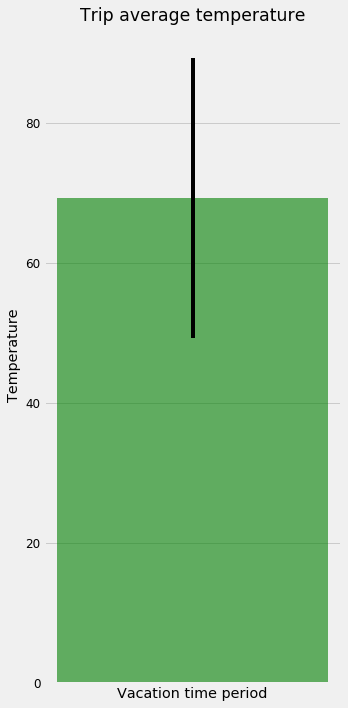

In [89]:
calctemps(datetime(2018,1,1),datetime(2018,1,20))